# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [17]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Architecture of the Policy

In [18]:
env = gym.make('Acrobot-v1')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
action space: Discrete(3)


In [19]:
env.action_space.n

3

### 3. Train the Agent with REINFORCE

In [36]:

policy = Policy(s_size=6, a_size=3 ).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=2000, max_t=10000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
#scores = reinforce()
scores = reinforce(gamma=0.99995, max_t=2000)

Episode 100	Average Score: -498.90
Episode 200	Average Score: -166.12
Episode 300	Average Score: -119.96
Episode 400	Average Score: -114.55
Episode 500	Average Score: -111.61
Episode 600	Average Score: -105.74
Episode 700	Average Score: -107.97
Episode 800	Average Score: -107.61
Episode 900	Average Score: -103.22
Episode 1000	Average Score: -99.11
Episode 1100	Average Score: -96.90
Episode 1200	Average Score: -95.21
Episode 1300	Average Score: -92.76
Episode 1400	Average Score: -93.34
Episode 1500	Average Score: -88.46
Episode 1600	Average Score: -89.69
Episode 1700	Average Score: -96.95
Episode 1800	Average Score: -98.45
Episode 1900	Average Score: -98.00
Episode 2000	Average Score: -93.47


### 4. Plot the Scores

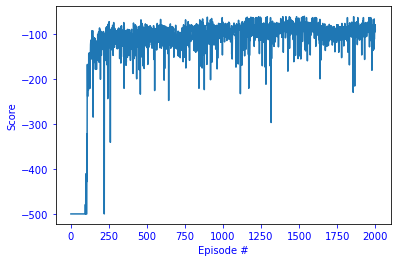

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='x', colors='blue')
ax.tick_params(axis='y', colors='blue')
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score', color='blue')
plt.xlabel('Episode #', color='blue')
plt.show()

### 5. Watch a Smart Agent!

In [ ]:
# Updated with add-on from Udacity online workspace
env = gym.make('Acrobot-v1')
state = env.reset()

for t in range(1000):
    action, _ = policy.act(state)
    env.render() 
    state, reward, done, _ = env.step(action)
    if done:
        print('you win after:',t)
        break 


Exception ignored in: <function Viewer.__del__ at 0x0000022B44DF34C8>
Traceback (most recent call last):
  File "c:\rl_githubs\gym-master\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "c:\rl_githubs\gym-master\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\ProgramData\Anaconda3\envs\keraspy37\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\ProgramData\Anaconda3\envs\keraspy37\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\ProgramData\Anaconda3\envs\keraspy37\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x0000022B49A9BC28; to 'Win32Window' at 0x0000022B49E7BC88>,)


In [35]:
env.close()